# Sentiment Analysis and Word Clouds of Wes Anderson's Movies

In [1]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

import requests
import nltk
#from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import re
from wordcloud import WordCloud
import torch
import torch.nn.functional as F

from tqdm import tqdm 
import time  

In [42]:
# Importing Datasets
df1 = pd.read_csv('grand_budapest.csv')
df2 = pd.read_csv('royal_tenenbaums.csv')
df3 = pd.read_csv('moonrise_kingdom.csv')
df4 = pd.read_csv('isle_of_dogs.csv')
df5 = pd.read_csv('mr_fox.csv')
df6 = pd.read_csv('asteroid_city.csv')
df7 = pd.read_csv('french_dispatch.csv')

## Quick EDA and a little bit of cleaning

In [43]:
# List of dataframes
dataframes = [df1, df2, df3, df4, df5, df6, df7]

for i, df in enumerate(dataframes, start=1):
    print(f"DataFrame {i} has {len(df)} reviews")

DataFrame 1 has 500 reviews
DataFrame 2 has 499 reviews
DataFrame 3 has 499 reviews
DataFrame 4 has 489 reviews
DataFrame 5 has 454 reviews
DataFrame 6 has 500 reviews
DataFrame 7 has 500 reviews


In [44]:
df1[df1['text'] == 'No text available'].head(2)

,title,text,rating
4,"""There are still faint glimmers of civilizatio...",No text available,10
5,Wes Anderson's Best?,No text available,9


In [45]:
# Replace 'No text available' in the 'text' column with the value from the 'title' column
for df in dataframes:
    df.loc[df['text'] == 'No text available', 'text'] = df['title']

df1[4:6]

,title,text,rating
4,"""There are still faint glimmers of civilizatio...","""There are still faint glimmers of civilizatio...",10
5,Wes Anderson's Best?,Wes Anderson's Best?,9


In [46]:
for i, df in enumerate(dataframes, start=1):
    count = df[df['rating'] == 'No rating available'].shape[0]
    print(f"Dataframe {i} has {count} rows with 'No rating available'")

Dataframe 1 has 18 rows with 'No rating available'
Dataframe 2 has 35 rows with 'No rating available'
Dataframe 3 has 18 rows with 'No rating available'
Dataframe 4 has 18 rows with 'No rating available'
Dataframe 5 has 19 rows with 'No rating available'
Dataframe 6 has 8 rows with 'No rating available'
Dataframe 7 has 13 rows with 'No rating available'


In [48]:
# Drop rows with 'No rating available'
for df in dataframes:
    df.drop(df[df['rating'] == 'No rating available'].index, inplace=True)
    df.reset_index(drop=True, inplace=True)

# Change rating column type to integer
for df in dataframes:
    df['rating'] = df['rating'].astype(int)
    
df1['rating'].value_counts()

10    121
9      85
8      75
1      55
5      32
6      28
7      25
3      22
2      20
4      19
Name: rating, dtype: int64

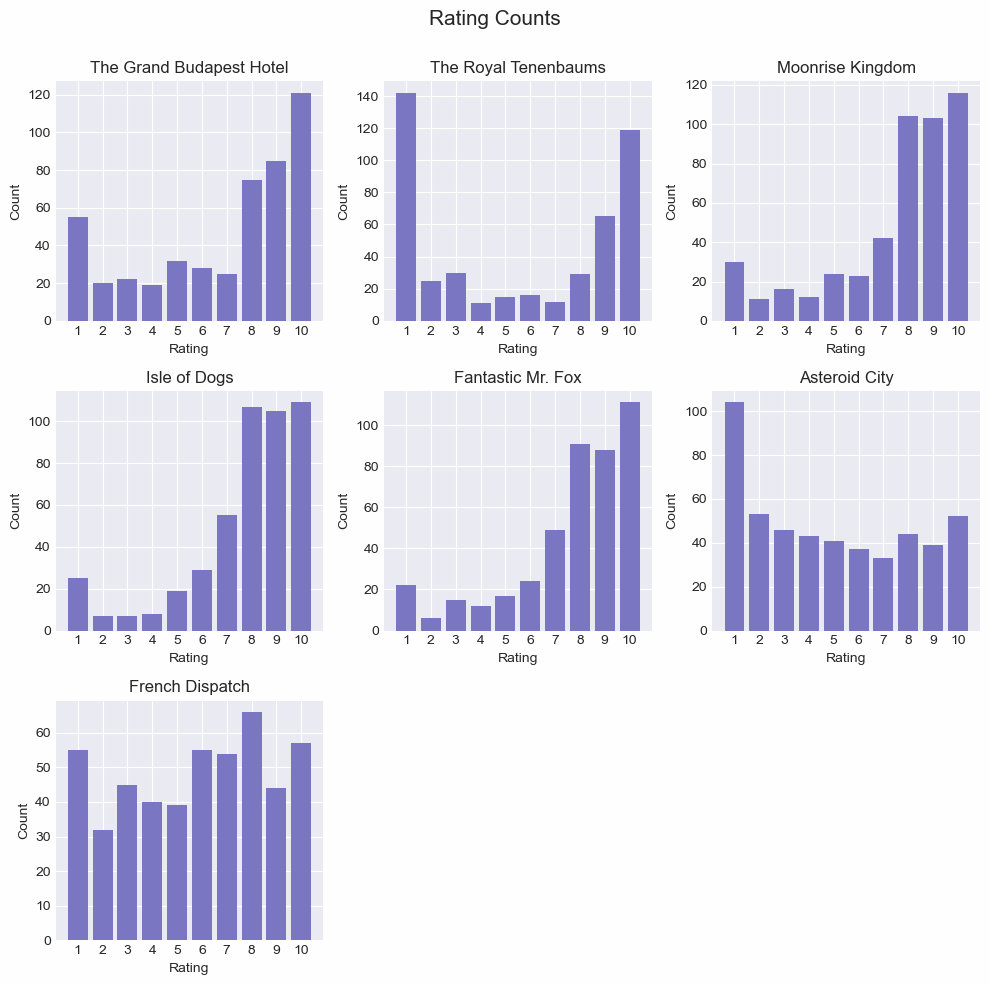

In [49]:
df_title = ['The Grand Budapest Hotel', 'The Royal Tenenbaums', 'Moonrise Kingdom', 'Isle of Dogs', 'Fantastic Mr. Fox', 'Asteroid City', 'French Dispatch']

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for i, df in enumerate(dataframes):
    row, col = divmod(i, 3)
    value_counts = df['rating'].value_counts().sort_index()
    axes[row, col].bar(value_counts.index, value_counts.values)
    axes[row, col].set_title(f'{df_title[i]}')
    axes[row, col].set_xlabel('Rating')
    axes[row, col].set_ylabel('Count')
    axes[row, col].set_xticks(range(1, 11))

# Hide any remaining empty subplots
for j in range(len(dataframes), 9):
    row, col = divmod(j, 3)
    fig.delaxes(axes[row, col])

fig.suptitle('Rating Counts\n', fontsize=15)
plt.tight_layout()
plt.show()

## RoBERTa Trained Model Sentiment Analysis + Text Cleaning

In [50]:
example = df1['text'][0]
example

"My heart is still rolling from the escape to 30's Europe this afternoon, and without jet lag. This movie is an inspiration, a dream, a walk through a painting and a study of humanity.Ralph Fiennes\ufeff is a phenomenon as M. Gustave. his interactions with every cast member and especially newcomer Tony Revolori are fantastic. The later holds his own weight beyond belief and the entire film is an amazing adventure with James Bond style chases, a large murder mystery, the best placed cussing and of course the sensational cinematography. The sets, models, angles and even the most nondescript characters come to life each on their own and together as a symphony of beauty. It's freaking brilliant; The Grand Budapest Hotel."

In [51]:
# Function to download stop words from a URL
def get_stopwords(url):
    response = requests.get(url)
    stopwords = response.text.splitlines()
    return set(stopwords)

# URL of the stopwords file
stopwords_url = 'https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt'

# Download stop words
stop_words = get_stopwords(stopwords_url)

In [52]:
# Text Cleaning: Discard unnecessary words, convert to lowercase text, and remove punctuation mark

# Tokenize the text into words and convert in to lowercase
words = word_tokenize(example.lower())

# Remove stop words from the text
filtered_words = [word for word in words if word not in stop_words]

# Join the filtered words back into a string and lowercase the text
filtered_example = ' '.join(filtered_words)

# Remove punctuation mark
cleaned_example = filtered_example.translate(str.maketrans('', '', string.punctuation))

print(cleaned_example)

heart rolling escape 30 s europe afternoon  jet lag  movie inspiration  dream  walk painting study humanityralph fiennes﻿ phenomenon m gustave  interactions cast newcomer tony revolori fantastic  holds weight belief entire film amazing adventure james bond style chases  murder mystery  cussing sensational cinematography  sets  models  angles nondescript characters life symphony beauty  s freaking brilliant  grand budapest hotel 


In [59]:
def text_cleaning(text):
    """
    Discard unnecessary words, convert to lowercase text, and remove punctuation mark.

    Args:
    - text (str): Input text to clean.

    Returns:
    - str: Cleaned text.
    """
    # Tokenize the text into words and convert in to lowercase
    words = word_tokenize(text.lower())
    
    # Filter out stop words from the text
    filtered_words = [word for word in words if word not in stop_words]
    
    # Join the filtered words back into a string
    filtered_text = ' '.join(filtered_words)
    
    # Remove punctuation mark
    cleaned_text = filtered_text.translate(str.maketrans('', '', string.punctuation))
    
    return cleaned_text

In [54]:
# Specify the model name
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

# Load the tokenizer for the model
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [55]:
# Encode the text and truncate to maximum length of 512 tokens
encoded_text = tokenizer(cleaned_example, truncation=True, max_length=512, return_tensors='pt') # PyTorch tensors

# Pass the tokenized text through the model to get the raw output (logits).
output = model(**encoded_text)

# Extract the scores and apply softmax to convert them into probabilities
scores = output.logits[0].detach().numpy()
scores = softmax(scores)

# Define the sentiment labels.
score_labels = ['neg', 'neu', 'pos']

# Create a dictionary to map the sentiment labels to their corresponding scores.
scores_dict = {
    score_labels[0] : scores[0],  
    score_labels[1] : scores[1], 
    score_labels[2] : scores[2]  
}

scores_dict

{'neg': 0.0033135584, 'neu': 0.10199064, 'pos': 0.8946958}

The example text have a high positive sentiment.

In [60]:
# Define the sentiment labels.
score_labels = ['neg', 'neu', 'pos']

def polarity_scores(text):
    """
    Calculate polarity scores for a given text using a pre-trained sentiment analysis model.

    Args:
    - text (str): Input text for sentiment analysis.

    Returns:
    - dict: Dictionary containing sentiment scores ('neg', 'neu', 'pos').
    """
    # Encode the text and truncate to maximum length of 512 tokens
    encoded_text = tokenizer(text, truncation=True, max_length=512, return_tensors='pt') # PyTorch tensors
    
    # Pass the tokenized text through the model to get the raw output (logits).
    output = model(**encoded_text)
    
    # Extract the scores and apply softmax to convert them into probabilities
    scores = output.logits[0].detach().numpy()
    scores = softmax(scores)
    
    # Create a dictionary mapping sentiment labels to their corresponding scores
    scores_dict = {
        score_labels[0]: scores[0],
        score_labels[1]: scores[1],
        score_labels[2]: scores[2]
    }
    
    return scores_dict

In [61]:
# Initialize tqdm to track progress
# tqdm.pandas()

# Define a function to process each row
def process_row(row):
        # Apply discard_stopwords function
        cleaned_text = text_cleaning(row)
        # Apply polarity_scores function
        sentiment_scores = polarity_scores(cleaned_text)

        return pd.Series({
            'cleaned_text': cleaned_text,
            'neg_score': sentiment_scores['neg'],
            'neu_score': sentiment_scores['neu'],
            'pos_score': sentiment_scores['pos']
        })

In [35]:
# Apply the processing function to each row using progress_apply with tqdm
df1_processed = df1['text'].progress_apply(process_row)

# Concatenate the processed DataFrame with the rating column from original DataFrame
df1_processed = pd.concat([df1['rating'], df1_processed], axis=1)

100%|██████████████████████████████████████████████████████████████████████████████| 482/482 [1:14:36<00:00,  9.29s/it]


In [11]:
df1_processed.head(1)

,rating,cleaned_text,neg_score,neu_score,pos_score
0,10,heart rolling escape 30 s europe afternoon je...,0.003314,0.101991,0.894696


In [47]:
df1_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rating        482 non-null    int64  
 1   cleaned_text  478 non-null    object 
 2   neg_score     482 non-null    float64
 3   neu_score     482 non-null    float64
 4   pos_score     482 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 19.0+ KB


In [46]:
df1_processed[df1_processed.isna().any(axis=1)]

,rating,cleaned_text,neg_score,neu_score,pos_score
14,10,NaN,0.225575,0.373126,0.401299
20,4,NaN,0.225575,0.373126,0.401299
332,8,NaN,0.225575,0.373126,0.401299
459,6,NaN,0.225575,0.373126,0.401299


There are some missing values in the cleaned text column. Let's see what caused it.

In [60]:
df1.iloc[[14, 20, 332, 459]]

,title,text,rating
14,So so good.,So so good.,10
20,Same old Same old,Same old Same old,4
332,Not a Zero,Not a Zero,8
459,Not that good,Not that good,6


Let's check if the words exist in the stopwords list.

In [66]:
words_to_check = ['so', 'good', 'old', 'not', 'zero', 'that']

for word in words_to_check:
    if word in stop_words:
        print(f"{word} is in the dictionary")
    else:
        print(f"{word} is not in the dictionary")

so is in the dictionary
good is in the dictionary
old is in the dictionary
not is in the dictionary
zero is in the dictionary
that is in the dictionary


All of them are in the stopwords list. Let's just remove the rows that have missing values. 

In [67]:
df1_processed.dropna(inplace=True)

df1_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 0 to 481
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rating        478 non-null    int64  
 1   cleaned_text  478 non-null    object 
 2   neg_score     478 non-null    float64
 3   neu_score     478 non-null    float64
 4   pos_score     478 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 22.4+ KB


Let's now apply the same processing to all the other dataframes.

In [36]:
# Dataframe 2
df2_processed = df2['text'].progress_apply(process_row)
df2_processed = pd.concat([df2['rating'], df2_processed], axis=1)

# Dataframe 3
df3_processed = df3['text'].progress_apply(process_row)
df3_processed = pd.concat([df3['rating'], df3_processed], axis=1)

# Dataframe 4
df4_processed = df4['text'].progress_apply(process_row)
df4_processed = pd.concat([df4['rating'], df4_processed], axis=1)

# Dataframe 5
df5_processed = df5['text'].progress_apply(process_row)
df5_processed = pd.concat([df5['rating'], df5_processed], axis=1)

# Dataframe 6
df6_processed = df6['text'].progress_apply(process_row)
df6_processed = pd.concat([df6['rating'], df6_processed], axis=1)

# Dataframe 7
df7_processed = df7['text'].progress_apply(process_row)
df7_processed = pd.concat([df7['rating'], df7_processed], axis=1)

100%|████████████████████████████████████████████████████████████████████████████████| 487/487 [42:57<00:00,  5.29s/it]


In [67]:
# Dataframe 4
import datetime
start_time = datetime.datetime.now()
print(f"Start time: {start_time}")

df4_processed = df4['text'].apply(process_row)
df4_processed = pd.concat([df4['rating'], df4_processed], axis=1)

end_time = datetime.datetime.now()
print(f"End time: {end_time}")
execution_time = end_time - start_time
print(f"Execution time: {execution_time}")

Start time: 2024-07-30 13:06:23.520076
End time: 2024-07-30 13:54:00.282115
Execution time: 0:47:36.762039


In [75]:
processed_dataframes = [df1_processed, df2_processed, df3_processed, df4_processed, df5_processed, df6_processed, df7_processed]

for i, df in enumerate(processed_dataframes, start=1):
    print(f"Dataframe {i} has {df.isna().any(axis=1).sum()} missing values")

Dataframe 1 has 0 missing values
Dataframe 2 has 6 missing values
Dataframe 3 has 2 missing values
Dataframe 4 has 6 missing values
Dataframe 5 has 3 missing values
Dataframe 6 has 7 missing values
Dataframe 7 has 5 missing values


In [78]:
# Drop rows of missing values
for i, df in enumerate(processed_dataframes, start=1):
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

# Check for missing values
for i, df in enumerate(processed_dataframes, start=1):
    print(f"Dataframe {i} has {df.isna().any(axis=1).sum()} missing values")

Dataframe 1 has 0 missing values
Dataframe 2 has 0 missing values
Dataframe 3 has 0 missing values
Dataframe 4 has 0 missing values
Dataframe 5 has 0 missing values
Dataframe 6 has 0 missing values
Dataframe 7 has 0 missing values


In [80]:
# Save the processed dataframes
df1_processed.to_csv('df1_processed.csv', index=False)
df2_processed.to_csv('df2_processed.csv', index=False)
df3_processed.to_csv('df3_processed.csv', index=False)
df4_processed.to_csv('df4_processed.csv', index=False)
df5_processed.to_csv('df5_processed.csv', index=False)
df6_processed.to_csv('df6_processed.csv', index=False)
df7_processed.to_csv('df7_processed.csv', index=False)

In [50]:
combined_processed_df.columns

Index(['rating', 'cleaned_text', 'neg_score', 'neu_score', 'pos_score',
       'source', 'movie'],
      dtype='object')

In [52]:
# Combined the dataframes to create a single dataframe

# Add a column to each dataframe to identify the source
df1_processed['movie'] = 'The Grand Budapest Hotel'
df2_processed['movie'] = 'The Royal Tenenbaums'
df3_processed['movie'] = 'Moonrise Kingdom'
df4_processed['movie'] = 'Isle of Dogs'
df5_processed['movie'] = 'Fantastic Mr. Fox'
df6_processed['movie'] = 'Asteroid City'
df7_processed['movie'] = 'The French Dispatch'

# Concatenate the dataframes
combined_processed_df = pd.concat([df1_processed, df2_processed, df3_processed, df4_processed, df5_processed, df6_processed, df7_processed])

# Reorcer columns placement
combined_processed_df =combined_processed_df[['movie', 'rating', 'cleaned_text', 'neg_score', 'neu_score', 'pos_score']]

# Reset the index (optional)
combined_processed_df.reset_index(drop=True, inplace=True)

# Display the combined dataframe
combined_processed_df.sample(10)

,movie,rating,cleaned_text,neg_score,neu_score,pos_score
2735,Asteroid City,10,nuclear desert americans nukular dessert n...,0.123857,0.755800,0.120343
1756,Isle of Dogs,6,pretentious snorefests s muchthis adventure ...,0.397245,0.510577,0.092178
472,The Grand Budapest Hotel,7,writerdirector wes anderson translated story s...,0.078334,0.853355,0.068311
1735,Isle of Dogs,10,animations idiosyncratic fun dogs fur real a...,0.013766,0.546056,0.440178
3119,The French Dispatch,1,movie sucks super cast stories plain stupi...,0.922889,0.068534,0.008577
3247,The French Dispatch,7,french dispatch relentless crowded whirling t...,0.027759,0.515010,0.457231
108,The Grand Budapest Hotel,10,perfection anderson,0.021754,0.309374,0.668872
1088,Moonrise Kingdom,8,movie wes anderson movies leading,0.007930,0.921887,0.070183
2893,The French Dispatch,1,movie boring slow sense amazing actors dumb...,0.752073,0.205257,0.042669
2454,Asteroid City,2,staggering tonnage clunky framing device stars...,0.032572,0.706834,0.260594


In [53]:
combined_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3282 entries, 0 to 3281
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movie         3282 non-null   object 
 1   rating        3282 non-null   int64  
 2   cleaned_text  3282 non-null   object 
 3   neg_score     3282 non-null   float64
 4   neu_score     3282 non-null   float64
 5   pos_score     3282 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 154.0+ KB


In [54]:
# Save the processed dataframe
combined_processed_df.to_csv('combined_processed_df.csv', index=False)

## WorldCloud

In [51]:
df1_processed = pd.read_csv('df1_processed.csv')
df2_processed = pd.read_csv('df2_processed.csv')
df3_processed = pd.read_csv('df3_processed.csv')
df4_processed = pd.read_csv('df4_processed.csv')
df5_processed = pd.read_csv('df5_processed.csv')
df6_processed = pd.read_csv('df6_processed.csv')
df7_processed = pd.read_csv('df7_processed.csv')

### The Grand Budapest Hotel

In [12]:
# Combine all text in the 'cleaned_text' column into a single string
text = " ".join(review.lower() for review in df1_processed['cleaned_text'])

# Generate the word cloud
df1_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

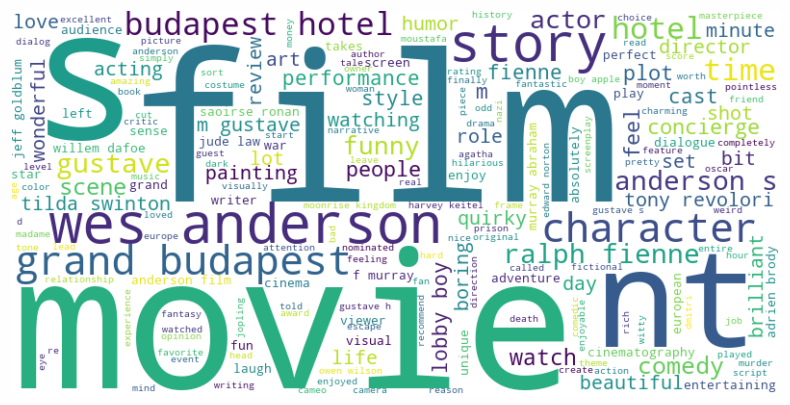

In [13]:
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(df1_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Let's remove common words that are not meaningful for the analysis.

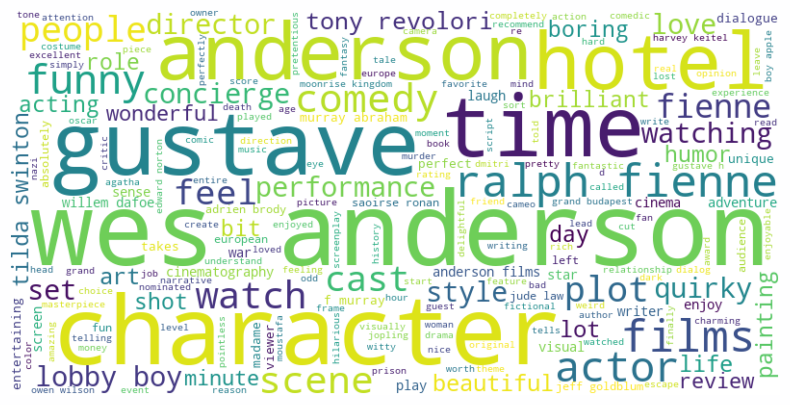

In [14]:
# Combine all text in the 'cleaned_text' column into a single string
df1_text = " ".join(review.lower() for review in df1_processed['cleaned_text'])

# List of words and phrases to remove
removals = [
    'nt',
    's',
    'film',
    'movie',
    'movies',
    'story',
    'm',
    'grand budapest hotel'
]

# Remove each word/phrase using regular expressions
for removal in removals:
    df1_text = re.sub(rf'\b{re.escape(removal)}\b', '', df1_text, flags=re.IGNORECASE)

# Remove extra whitespace resulting from the replacements
df1_text = re.sub(r'\s+', ' ', df1_text).strip()

# Generate the word cloud
df1_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(df1_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(df1_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
# Create a dataframe with the list of words
words_list = df1_text.split()
words_df1 = pd.DataFrame(words_list, columns=['word'])
words_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21096 entries, 0 to 21095
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    21096 non-null  object
dtypes: object(1)
memory usage: 164.9+ KB


### The Royal Tenenbaums

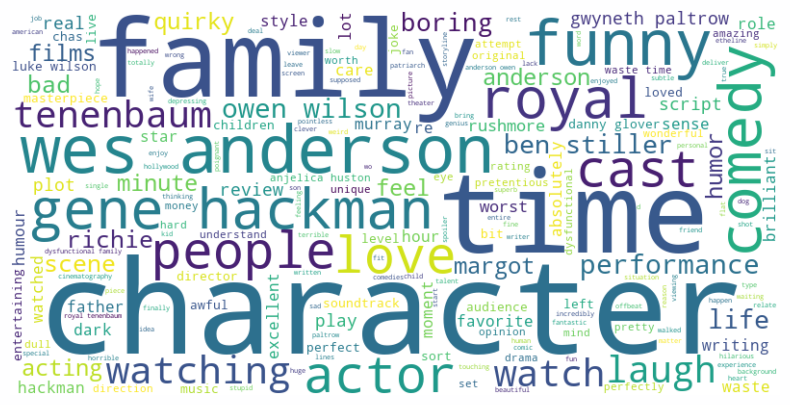

In [21]:
# Combine all text in the 'cleaned_text' column into a single string
df2_text = " ".join(review.lower() for review in df2_processed['cleaned_text'])

# List of words and phrases to remove
removals = [
    'nt',
    's',
    'film',
    'movie',
    'movies',
    'story',
    'm',
    'royal tenenbaums'
]

# Remove each word/phrase using regular expressions
for removal in removals:
    df2_text = re.sub(rf'\b{re.escape(removal)}\b', '', df2_text, flags=re.IGNORECASE)

# Remove extra whitespace resulting from the replacements
df2_text = re.sub(r'\s+', ' ', df2_text).strip()


# Generate the word cloud
df2_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(df2_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(df2_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [38]:
# Create a dataframe with the list of words
words_list = df2_text.split()
words_df2 = pd.DataFrame(words_list, columns=['word'])
words_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12951 entries, 0 to 12950
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    12951 non-null  object
dtypes: object(1)
memory usage: 101.3+ KB


### Moonrise Kingdom

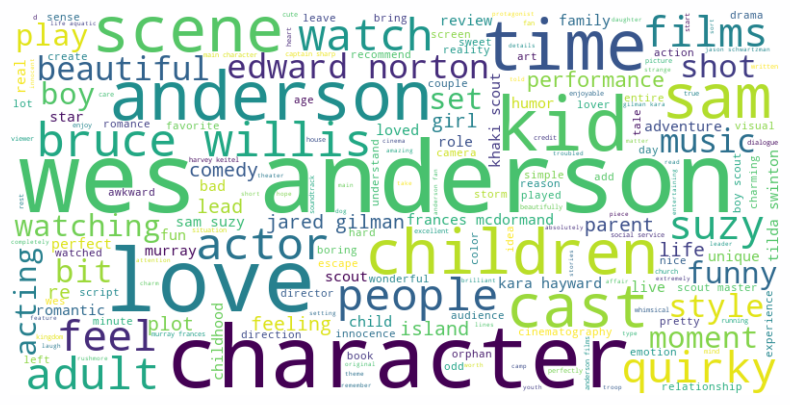

In [27]:
# Combine all text in the 'cleaned_text' column into a single string
df3_text = " ".join(review.lower() for review in df3_processed['cleaned_text'])

# List of words and phrases to remove
removals = [
    'nt',
    's',
    'film',
    'movie',
    'movies',
    'story',
    'm',
    'moonrise kingdom'
]

# Remove each word/phrase using regular expressions
for removal in removals:
    df3_text = re.sub(rf'\b{re.escape(removal)}\b', '', df3_text, flags=re.IGNORECASE)

# Remove extra whitespace resulting from the replacements
df3_text = re.sub(r'\s+', ' ', df3_text).strip()

# Generate the word cloud
df3_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(df3_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(df3_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [39]:
# Create a dataframe with the list of words
words_list = df3_text.split()
words_df3 = pd.DataFrame(words_list, columns=['word'])

words_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19369 entries, 0 to 19368
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    19369 non-null  object
dtypes: object(1)
memory usage: 151.4+ KB


### Isle of Dogs

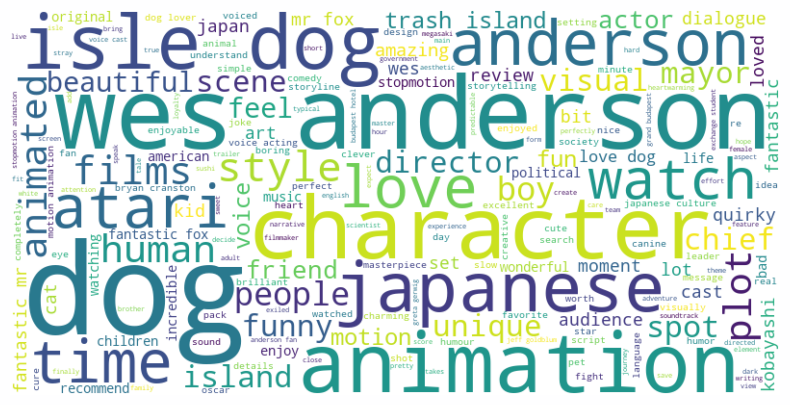

In [29]:
# Combine all text in the 'cleaned_text' column into a single string
df4_text = " ".join(review.lower() for review in df4_processed['cleaned_text'])

# List of words and phrases to remove
removals = [
    'nt',
    's',
    'film',
    'movie',
    'movies',
    'story',
    'm',
    'isle of dogs'
]

# Remove each word/phrase using regular expressions
for removal in removals:
    df4_text = re.sub(rf'\b{re.escape(removal)}\b', '', df4_text, flags=re.IGNORECASE)

# Remove extra whitespace resulting from the replacements
df4_text = re.sub(r'\s+', ' ', df4_text).strip()

# Generate the word cloud
df4_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(df4_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(df4_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [40]:
# Create a dataframe with the list of words
words_list = df4_text.split()
words_df4 = pd.DataFrame(words_list, columns=['word'])

words_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13817 entries, 0 to 13816
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    13817 non-null  object
dtypes: object(1)
memory usage: 108.1+ KB


### Fantastic Mr. Fox

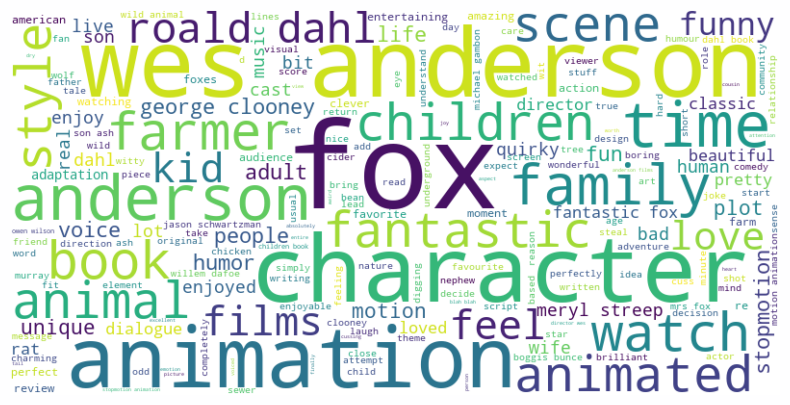

In [31]:
# Combine all text in the 'cleaned_text' column into a single string
df5_text = " ".join(review.lower() for review in df5_processed['cleaned_text'])

# List of words and phrases to remove
removals = [
    'nt',
    's',
    'film',
    'movie',
    'movies',
    'story',
    'm',
    'fantastic mr fox',
    'mr'
]

# Remove each word/phrase using regular expressions
for removal in removals:
    df5_text = re.sub(rf'\b{re.escape(removal)}\b', '', df5_text, flags=re.IGNORECASE)

# Remove extra whitespace resulting from the replacements
df5_text = re.sub(r'\s+', ' ', df5_text).strip()

# Generate the word cloud
df5_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(df5_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(df5_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [41]:
# Create a dataframe with the list of words
words_list = df5_text.split()
words_df5 = pd.DataFrame(words_list, columns=['word'])

words_df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16050 entries, 0 to 16049
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    16050 non-null  object
dtypes: object(1)
memory usage: 125.5+ KB


### Asteroid City

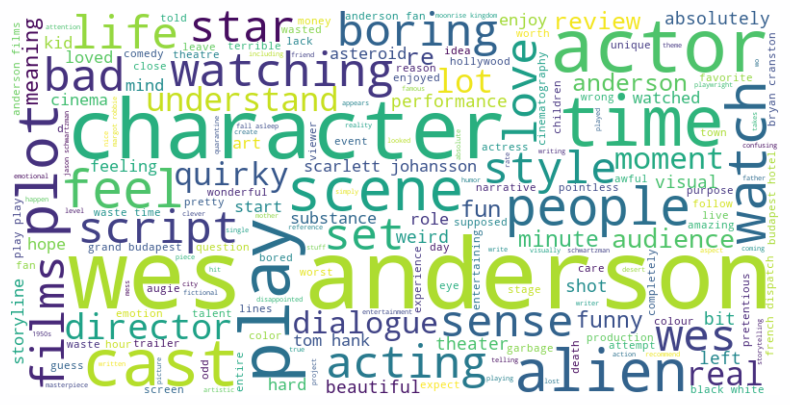

In [33]:
# Combine all text in the 'cleaned_text' column into a single string
df6_text = " ".join(review.lower() for review in df6_processed['cleaned_text'])

# List of words and phrases to remove
removals = [
    'nt',
    's',
    'film',
    'movie',
    'movies',
    'story',
    'm',
    'asteroid city'
]

# Remove each word/phrase using regular expressions
for removal in removals:
    df6_text = re.sub(rf'\b{re.escape(removal)}\b', '', df6_text, flags=re.IGNORECASE)

# Remove extra whitespace resulting from the replacements
df6_text = re.sub(r'\s+', ' ', df6_text).strip()

# Generate the word cloud
df6_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(df6_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(df6_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [42]:
# Create a dataframe with the list of words
words_list = df6_text.split()
words_df6 = pd.DataFrame(words_list, columns=['word'])

words_df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17336 entries, 0 to 17335
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    17336 non-null  object
dtypes: object(1)
memory usage: 135.6+ KB


### The French Dispatch

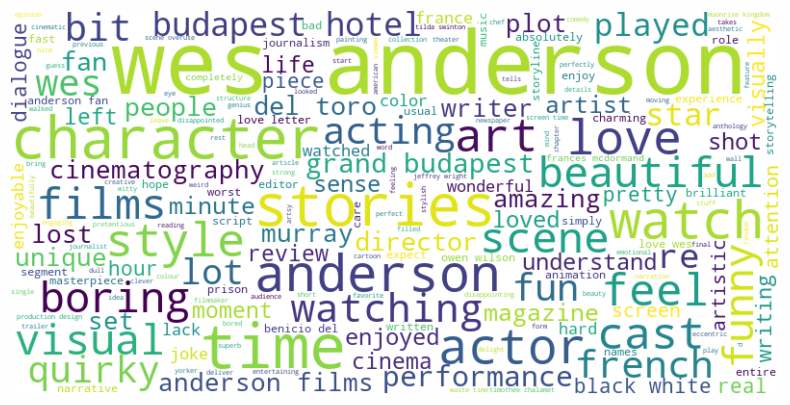

In [35]:
# Combine all text in the 'cleaned_text' column into a single string
df7_text = " ".join(review.lower() for review in df7_processed['cleaned_text'])

# List of words and phrases to remove
removals = [
    'nt',
    's',
    'film',
    'movie',
    'movies',
    'story',
    'm',
    'french dispatch'
]

# Remove each word/phrase using regular expressions
for removal in removals:
    df7_text = re.sub(rf'\b{re.escape(removal)}\b', '', df7_text, flags=re.IGNORECASE)

# Remove extra whitespace resulting from the replacements
df7_text = re.sub(r'\s+', ' ', df7_text).strip()

# Generate the word cloud
df7_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(df7_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(df7_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [43]:
# Create a dataframe with the list of words
words_list = df7_text.split()
words_df7 = pd.DataFrame(words_list, columns=['word'])

words_df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11990 entries, 0 to 11989
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    11990 non-null  object
dtypes: object(1)
memory usage: 93.8+ KB


In [48]:
# Combined the dataframes to create a single dataframe

# Add a column to each dataframe to identify the source
words_df1['movie'] = 'The Grand Budapest Hotel'
words_df2['movie'] = 'The Royal Tenenbaums'
words_df3['movie'] = 'Moonrise Kingdom'
words_df4['movie'] = 'Isle of Dogs'
words_df5['movie'] = 'Fantastic Mr. Fox'
words_df6['movie'] = 'Asteroid City'
words_df7['movie'] = 'The French Dispatch'

# Concatenate the dataframes
words_df = pd.concat([words_df1, words_df2, words_df3, words_df4, words_df5, words_df6, words_df7])

# Reset the index (optional)
words_df.reset_index(drop=True, inplace=True)

# Reorder the columns
words_df = words_df[['movie', 'word']]

# Display the combined dataframe
words_df.sample(10)

,movie,word
74240,Fantastic Mr. Fox,fan
79886,Fantastic Mr. Fox,bunce
33452,The Royal Tenenbaums,director
41168,Moonrise Kingdom,storm
97249,Asteroid City,short
28116,The Royal Tenenbaums,talent
86894,Asteroid City,wasted
102733,The French Dispatch,lyna
106081,The French Dispatch,films
66056,Isle of Dogs,engaging


In [49]:
# Save the words dataframe to a CSV file
words_df.to_csv('words_df.csv', index=False)

## Emotion Classification

In [163]:
# Specify the model name
MODEL = f"michellejieli/emotion_text_classifier"

# Load the tokenizer for the model
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Load the pre-trained model
emotion_model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/413 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/280 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

**DistilRoBERTa-base** is a transformer model that performs sentiment analysis. The model predicts **6 Ekman emotions and a neutral class**. These emotions include anger, disgust, fear, joy, neutrality, sadness, and surprise.

In [164]:
example = df1_processed['cleaned_text'][0]
example

'heart rolling escape 30 s europe afternoon  jet lag  movie inspiration  dream  walk painting study humanityralph fiennes\ufeff phenomenon m gustave  interactions cast newcomer tony revolori fantastic  holds weight belief entire film amazing adventure james bond style chases  murder mystery  cussing sensational cinematography  sets  models  angles nondescript characters life symphony beauty  s freaking brilliant  grand budapest hotel '

In [165]:
# Initialize a list to store emotion scores for each review
emotion_scores = []

# Tokenize the review
inputs = tokenizer(example, return_tensors='pt', truncation=True, max_length=512)

# Get emotion scores
with torch.no_grad():
    outputs = emotion_model(**inputs)
    logits = outputs.logits

# Apply softmax to get probabilities
probs = F.softmax(logits, dim=-1)

# Get the emotion labels
emotion_labels = emotion_model.config.id2label

# Store the emotion scores for the current review
emotion_scores = {emotion_labels[i]: prob.item() for i, prob in enumerate(probs[0])}

print(emotion_scores)

{'anger': 0.00172374676913023, 'disgust': 0.00015986133075784892, 'fear': 0.0015485553303733468, 'joy': 0.970878541469574, 'neutral': 0.021965643391013145, 'sadness': 0.001902156276628375, 'surprise': 0.0018215372692793608}


In [177]:
def classify_emotions(dataframe):
    # Initialize a list to store emotion scores for each review
    emotion_scores = []

    # Process each review
    for review in dataframe['cleaned_text']:
        # Tokenize the review with truncation to ensure it doesn't exceed the maximum length
        inputs = tokenizer(review, return_tensors='pt', truncation=True, max_length=512)

        # Get emotion scores
        with torch.no_grad():
            outputs = emotion_model(**inputs)
            logits = outputs.logits

        # Apply softmax to get probabilities
        probs = F.softmax(logits, dim=-1)

        # Get the emotion labels
        emotion_labels = emotion_model.config.id2label

        # Store the emotion scores for the current review
        review_emotions = {emotion_labels[i]: prob.item() for i, prob in enumerate(probs[0])}
        emotion_scores.append(review_emotions)

    # Convert the list of dictionaries to a DataFrame
    df_emotion = pd.DataFrame(emotion_scores)

    # Aggregate the emotion scores to get an overall profile
    overall_emotions = df_emotion.median()

    return df_emotion, overall_emotions

In [180]:
# Apply the function for each dataframe. (I'm not going to use loop here so I can easily debug when something's wrong.)
df1_emotions, df1_overall_emotions = classify_emotions(df1_processed)

In [185]:
df1_overall_emotions

anger       0.003883
disgust     0.000566
fear        0.002488
joy         0.698413
neutral     0.092559
sadness     0.007137
surprise    0.002340
dtype: float64

In [186]:
df2_emotions, df2_overall_emotions = classify_emotions(df2_processed)

df2_overall_emotions

anger       0.005805
disgust     0.000937
fear        0.003842
joy         0.410634
neutral     0.094863
sadness     0.016788
surprise    0.002440
dtype: float64

In [187]:
df3_emotions, df3_overall_emotions = classify_emotions(df3_processed)

df3_overall_emotions

anger       0.003017
disgust     0.000500
fear        0.002144
joy         0.794962
neutral     0.093071
sadness     0.006511
surprise    0.002115
dtype: float64

In [188]:
df4_emotions, df4_overall_emotions = classify_emotions(df4_processed)

df4_overall_emotions

anger       0.003399
disgust     0.000638
fear        0.002784
joy         0.699509
neutral     0.142864
sadness     0.006511
surprise    0.001928
dtype: float64

In [189]:
df5_emotions, df5_overall_emotions = classify_emotions(df5_processed)

df5_overall_emotions

anger       0.002687
disgust     0.000464
fear        0.001739
joy         0.870417
neutral     0.065692
sadness     0.004567
surprise    0.001884
dtype: float64

In [190]:
df6_emotions, df6_overall_emotions = classify_emotions(df6_processed)

df6_overall_emotions

anger       0.006903
disgust     0.000964
fear        0.004783
joy         0.316788
neutral     0.110566
sadness     0.022885
surprise    0.002378
dtype: float64

In [191]:
df7_emotions, df7_overall_emotions = classify_emotions(df7_processed)

df7_overall_emotions

anger       0.006649
disgust     0.000852
fear        0.003807
joy         0.558862
neutral     0.109421
sadness     0.015054
surprise    0.001892
dtype: float64

In [199]:
# List of all emotion Series
emotion_series_list = [df1_overall_emotions, df2_overall_emotions, df3_overall_emotions, df4_overall_emotions, df5_overall_emotions, df6_overall_emotions, df7_overall_emotions]

# Combine all emotion Series into a single DataFrame
combined_emotions_df = pd.concat(emotion_series_list, axis=1)

# Transpose the DataFrame to have a better view
combined_emotions_df = combined_emotions_df

# Define the column names
movie_title = words_df.columns

combined_emotions_df.columns = ['grand_budapest', 'royal_tenenbaums', 'moonrise_kingdom', 'isle_of_dogs', 'mr_fox', 'asteroid_city', 'french_dispatch']

combined_emotions_df

,grand_budapest,royal_tenenbaums,moonrise_kingdom,isle_of_dogs,mr_fox,asteroid_city,french_dispatch
anger,0.003883,0.005805,0.003017,0.003399,0.002687,0.006903,0.006649
disgust,0.000566,0.000937,0.000500,0.000638,0.000464,0.000964,0.000852
fear,0.002488,0.003842,0.002144,0.002784,0.001739,0.004783,0.003807
joy,0.698413,0.410634,0.794962,0.699509,0.870417,0.316788,0.558862
neutral,0.092559,0.094863,0.093071,0.142864,0.065692,0.110566,0.109421
sadness,0.007137,0.016788,0.006511,0.006511,0.004567,0.022885,0.015054
surprise,0.002340,0.002440,0.002115,0.001928,0.001884,0.002378,0.001892


In [72]:
emotion_profile = pd.read_csv('emotion_profile.csv')

emotion_profile = emotion_profile.T

emotion_profile = emotion_profile[1:]
emotion_profile.reset_index(inplace=True)
emotion_profile.columns = ['movie', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

movie_title = ['The Grand Budapest Hotel', 'The Royal Tenenbaums', 'Moonrise Kingdom', 'Isle of Dogs', 'Fantastic Mr. Fox', 'Asteroid City', 'French Dispatch']

# Change values in movie column 
emotion_profile['movie'] = movie_title

emotion_profile

,movie,anger,disgust,fear,joy,neutral,sadness,surprise
0,The Grand Budapest Hotel,0.003883,0.000566,0.002488,0.698413,0.092559,0.007137,0.00234
1,The Royal Tenenbaums,0.005805,0.000937,0.003842,0.410634,0.094863,0.016788,0.00244
2,Moonrise Kingdom,0.003017,0.0005,0.002144,0.794962,0.093071,0.006511,0.002115
3,Isle of Dogs,0.003399,0.000638,0.002784,0.699509,0.142864,0.006511,0.001928
4,Fantastic Mr. Fox,0.002687,0.000464,0.001739,0.870417,0.065692,0.004567,0.001884
5,Asteroid City,0.006903,0.000964,0.004783,0.316788,0.110566,0.022885,0.002378
6,French Dispatch,0.006649,0.000852,0.003807,0.558862,0.109421,0.015054,0.001892


In [90]:
ep_test = emotion_profile[['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']]

# Convert anger column to list
ep_test = ep_test.melt(var_name='emotion', value_name='score')

# Repeat the movie titles to match the length of the DataFrame
movie_title_repeated = movie_title * (len(ep_test) // len(movie_title))

# Add any remaining titles to fill the rest of the DataFrame
if len(movie_title_repeated) < len(ep_test):
    movie_title_repeated += movie_title[:len(ep_test) - len(movie_title_repeated)]

# Add the movie titles as a new column
ep_test['movie'] = movie_title_repeated

ep_test

,emotion,score,movie
0,anger,0.003883,The Grand Budapest Hotel
1,anger,0.005805,The Royal Tenenbaums
2,anger,0.003017,Moonrise Kingdom
3,anger,0.003399,Isle of Dogs
4,anger,0.002687,Fantastic Mr. Fox
5,anger,0.006903,Asteroid City
6,anger,0.006649,French Dispatch
7,disgust,0.000566,The Grand Budapest Hotel
8,disgust,0.000937,The Royal Tenenbaums
9,disgust,0.0005,Moonrise Kingdom


In [95]:
# Change 'French Dispatch' in movie column to 'The French Dispatch'
ep_test['movie'] = ep_test['movie'].str.replace('French Dispatch', 'The French Dispatch')

ep_test

,emotion,score,movie
0,anger,0.003883,The Grand Budapest Hotel
1,anger,0.005805,The Royal Tenenbaums
2,anger,0.003017,Moonrise Kingdom
3,anger,0.003399,Isle of Dogs
4,anger,0.002687,Fantastic Mr. Fox
5,anger,0.006903,Asteroid City
6,anger,0.006649,The French Dispatch
7,disgust,0.000566,The Grand Budapest Hotel
8,disgust,0.000937,The Royal Tenenbaums
9,disgust,0.0005,Moonrise Kingdom


In [97]:
ep_test.to_csv('emotion_profile.csv')

In [205]:
# Save the dataframe 
combined_emotions_df.to_csv('emotion_profile.csv')

In [98]:
ep_test

,emotion,score,movie
0,anger,0.003883,The Grand Budapest Hotel
1,anger,0.005805,The Royal Tenenbaums
2,anger,0.003017,Moonrise Kingdom
3,anger,0.003399,Isle of Dogs
4,anger,0.002687,Fantastic Mr. Fox
5,anger,0.006903,Asteroid City
6,anger,0.006649,The French Dispatch
7,disgust,0.000566,The Grand Budapest Hotel
8,disgust,0.000937,The Royal Tenenbaums
9,disgust,0.0005,Moonrise Kingdom
